In [33]:
import pyspark
#sc = pyspark.SparkContext('local[*]')

In [34]:
!rm -rf metastore_db/*.lck

from pyspark.sql import SQLContext
sqlc = SQLContext(sc)

### Step 1
- Load the train and test sets
- Check the schema, the variables have their right types?
- If not, how to correctly load the datasets?

In [35]:
customSchema = 'PassengerId int, Survived double, Pclass int, Name string, Sex string, Age float, SibSp int, Parch int, Ticket string, Fare float, Cabin string, Embarked string'
train = sqlc.read.csv("train.csv", header=True, schema=customSchema)

In [36]:
train.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|     0.0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|     1.0|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|     1.0|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|     1.0|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|     0.0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
|          6|     0.0|     3|    Moran, Mr. James|  male|null|    0|    0|      

In [37]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

customSchema = StructType([StructField("PassengerId", IntegerType(), True),
                           StructField("Survived", DoubleType(), True),
                           StructField("Pclass", IntegerType(), True), 
                           StructField("Name", StringType(), True),
                           StructField("Sex", StringType(), True),
                           StructField("Age", DoubleType(), True),
                           StructField("SibSp", IntegerType(), True),
                           StructField("Parch", IntegerType(), True),
                           StructField("Ticket", StringType(), True),
                           StructField("Fare", DoubleType(), True),
                           StructField("Cabin", StringType(), True),
                           StructField("Embarked", StringType(), True)])

customSchema2 = StructType([StructField("PassengerId", IntegerType(), True),
                           StructField("Pclass", IntegerType(), True), 
                           StructField("Name", StringType(), True),
                           StructField("Sex", StringType(), True),
                           StructField("Age", DoubleType(), True),
                           StructField("SibSp", IntegerType(), True),
                           StructField("Parch", IntegerType(), True),
                           StructField("Ticket", StringType(), True),
                           StructField("Fare", DoubleType(), True),
                           StructField("Cabin", StringType(), True),
                           StructField("Embarked", StringType(), True)])

train = sqlc.read.csv("train.csv", header=True, schema=customSchema)
test = sqlc.read.csv("test.csv", header=True, schema=customSchema2)

In [38]:
train.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|     0.0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|     1.0|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|     1.0|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|     1.0|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|     0.0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

### Step 2
- Explore the features of your dataset
- You can use DataFrame's ***describe*** method to get summary statistics
    - hint: ***toPandas*** may be useful to ease the manipulation of small dataframes
- Are there any ***NaN*** values in your dataset?
- If so, define value/values to fill these ***NaN*** values
    - hint: ***na*** property of DataFrames provide several methods of handling NA values

In [39]:
train.where(train['Age'].isNull()).count()

177

In [40]:
train.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [41]:
{col:train.where(train[col].isNull()).count() for col in train.columns}

{'PassengerId': 0,
 'Survived': 0,
 'Pclass': 0,
 'Name': 0,
 'Sex': 0,
 'Age': 177,
 'SibSp': 0,
 'Parch': 0,
 'Ticket': 0,
 'Fare': 0,
 'Cabin': 687,
 'Embarked': 2}

In [42]:
train.groupby('Embarked').count().orderBy('count', ascending=False).take(1)[0].Embarked

'S'

In [43]:
# Calculating summary statistics and turning it into Pandas DF
train_desc = train.describe().toPandas().set_index('summary')

# Computing correlations between Survived and some features
print({col:train.stat.corr('Survived',col) for col in ['Pclass','Age','SibSp','Parch','Fare']})

# Checking which columns have NULL values
print({col:train.where(train[col].isNull()).count() for col in train.columns})

# Taking the mean age from the Pandas DF
ageMean = float(train_desc.loc['mean']['Age'])
print(ageMean)

embarked_mode = train.groupby('Embarked').count().orderBy('count', ascending=False).take(1)[0].Embarked
print(embarked_mode)

# Filling the Age in both train and test datasets
trainFilled = train.na.fill({'Age': ageMean, 'Embarked': embarked_mode})
testFilled = test.na.fill({'Age': ageMean, 'Embarked': embarked_mode})

from pyspark.sql import functions as F
train.groupby('Sex','PClass').agg(F.mean('age')).show()

{'Pclass': -0.3384810359610151, 'Age': 0.010539215871285682, 'SibSp': -0.0353224988857356, 'Parch': 0.08162940708348339, 'Fare': 0.2573065223849626}
{'PassengerId': 0, 'Survived': 0, 'Pclass': 0, 'Name': 0, 'Sex': 0, 'Age': 177, 'SibSp': 0, 'Parch': 0, 'Ticket': 0, 'Fare': 0, 'Cabin': 687, 'Embarked': 2}
29.69911764705882
S
+------+------+------------------+
|   Sex|PClass|          avg(age)|
+------+------+------------------+
|  male|     3|26.507588932806325|
|female|     3|             21.75|
|female|     1| 34.61176470588235|
|female|     2|28.722972972972972|
|  male|     2| 30.74070707070707|
|  male|     1| 41.28138613861386|
+------+------+------------------+



In [44]:
train_desc

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
summary,,,,,,,,,,,,
count,891,891,891,891,891,714,891,891,891,891,204,889
mean,446.0,0.3838383838383838,2.308641975308642,None,None,29.69911764705882,0.5230078563411896,0.38159371492704824,260318.54916792738,32.2042079685746,None,None
stddev,257.3538420152301,0.48659245426485753,0.8360712409770491,None,None,14.526497332334035,1.1027434322934315,0.8060572211299488,471609.26868834975,49.69342859718089,None,None
min,1,0.0,1,"""Andersson, Mr. August Edvard (""""Wennerstrom"""")""",female,0.42,0,0,110152,0.0,A10,C
max,891,1.0,3,"van Melkebeke, Mr. Philemon",male,80.0,8,6,WE/P 5735,512.3292,T,S


### Step 3
- How to handle categorical features?
    - hint: check the Estimators and Transformers
- Assemble all desired features into a Vector using the VectorAssembler Transformer
- Make sure to end up with a DataFrame with two columns: ***Survived*** and ***vFeatures***

In [45]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler

indexer1 = (StringIndexer()
           .setInputCol("Embarked")
           .setOutputCol("nEmbarked")
           .setHandleInvalid('skip'))

indexed1 = indexer1.fit(trainFilled).transform(trainFilled)

In [46]:
indexer1

StringIndexer_47c0bd076e03ad6e26c8

In [47]:
indexed1.show()

+-----------+--------+------+--------------------+------+-----------------+-----+-----+----------------+-------+-----+--------+---------+
|PassengerId|Survived|Pclass|                Name|   Sex|              Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|nEmbarked|
+-----------+--------+------+--------------------+------+-----------------+-----+-----+----------------+-------+-----+--------+---------+
|          1|     0.0|     3|Braund, Mr. Owen ...|  male|             22.0|    1|    0|       A/5 21171|   7.25| null|       S|      0.0|
|          2|     1.0|     1|Cumings, Mrs. Joh...|female|             38.0|    1|    0|        PC 17599|71.2833|  C85|       C|      1.0|
|          3|     1.0|     3|Heikkinen, Miss. ...|female|             26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|      0.0|
|          4|     1.0|     1|Futrelle, Mrs. Ja...|female|             35.0|    1|    0|          113803|   53.1| C123|       S|      0.0|
|          5|     0.0|     3|Allen

In [48]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler

# Applying Estimators and Transformators
# Here, I actually fitted and transformed them on the training data
# with the purpose of being able to check the intermediate steps

indexer1 = (StringIndexer()
           .setInputCol("Embarked")
           .setOutputCol("nEmbarked")
           .setHandleInvalid('skip'))

indexed1 = indexer1.fit(trainFilled).transform(trainFilled)

indexer2 = (StringIndexer()
           .setInputCol("Sex")
           .setOutputCol("nSex")
           .setHandleInvalid('skip'))

indexed2 = indexer2.fit(indexed1).transform(indexed1)

encoder1 = OneHotEncoder().setInputCol("nEmbarked").setOutputCol("vEmbarked")
encoded1 = encoder1.transform(indexed2)

# Using a VectorAssembler to put together all feature columns
assembler = VectorAssembler(inputCols=['Pclass',
                                       'Age',
                                       'SibSp',
                                       'Parch',
                                       'Fare',
                                       'nSex',
                                       'vEmbarked'], 
                            outputCol='vFeatures')

assembled = assembler.transform(encoded1)

# Keeping only the features and label columns to 
assembled2 = assembled.select("Survived","vFeatures")

In [49]:
assembled2.limit(5).toPandas()

,Survived,vFeatures
0,0.0,"[3.0, 22.0, 1.0, 0.0, 7.25, 0.0, 1.0, 0.0]"
1,1.0,"[1.0, 38.0, 1.0, 0.0, 71.2833, 1.0, 0.0, 1.0]"
2,1.0,"[3.0, 26.0, 0.0, 0.0, 7.925, 1.0, 1.0, 0.0]"
3,1.0,"[1.0, 35.0, 1.0, 0.0, 53.1, 1.0, 1.0, 0.0]"
4,0.0,"(3.0, 35.0, 0.0, 0.0, 8.05, 0.0, 1.0, 0.0)"


In [50]:
from pyspark.ml.feature import RFormula

rformula = RFormula(formula='Survived ~ Pclass + Age + SibSp + Parch + Fare + Sex + Embarked',
                    featuresCol='vFeatures', labelCol='Survived')
rmodel = rformula.fit(trainFilled)
features = rmodel.transform(trainFilled)
features.select('vFeatures', 'Survived').limit(5).toPandas()

,vFeatures,Survived
0,"[3.0, 22.0, 1.0, 0.0, 7.25, 1.0, 1.0, 0.0]",0.0
1,"[1.0, 38.0, 1.0, 0.0, 71.2833, 0.0, 0.0, 1.0]",1.0
2,"(3.0, 26.0, 0.0, 0.0, 7.925, 0.0, 1.0, 0.0)",1.0
3,"[1.0, 35.0, 1.0, 0.0, 53.1, 0.0, 1.0, 0.0]",1.0
4,"[3.0, 35.0, 0.0, 0.0, 8.05, 1.0, 1.0, 0.0]",0.0


### Step 4
- Apply a normalization Estimator of your choice to the ***features*** vector obtained in Step 3

In [51]:
from pyspark.ml.feature import StandardScaler

scaler = (StandardScaler()
          .setInputCol("vFeatures")
          .setOutputCol("scaledFeat")
          .setWithStd(True)
          .setWithMean(True))

scalerModel = scaler.fit(assembled2)
scaled = scalerModel.transform(assembled2)

In [52]:
scaled.select('scaledFeat', 'Survived').limit(5).toPandas()

,scaledFeat,Survived
0,"[0.8269128165243681, -0.5921480257661316, 0.43...",0.0
1,"[-1.5652278312782775, 0.6384304439468866, 0.43...",1.0
2,"[0.8269128165243681, -0.2845034083378771, -0.4...",1.0
3,"[-1.5652278312782775, 0.40769698087569567, 0.4...",1.0
4,"[0.8269128165243681, 0.40769698087569567, -0.4...",0.0


### Step 5
- Instead of doing transformations on separate steps, put everything together with a Pipeline

In [53]:
from pyspark.ml.pipeline import Pipeline

pipeline = Pipeline(stages=[indexer1,
                            indexer2,
                            encoder1,  
                            assembler,
                            scaler])

pipeline = Pipeline(stages=[rformula, scaler])

model = pipeline.fit(trainFilled)
scaled = model.transform(trainFilled)

In [54]:
scaled.select('Survived', 'scaledFeat').show(10)

+--------+--------------------+
|Survived|          scaledFeat|
+--------+--------------------+
|     0.0|[0.82691281652436...|
|     1.0|[-1.5652278312782...|
|     1.0|[0.82691281652436...|
|     1.0|[-1.5652278312782...|
|     0.0|[0.82691281652436...|
|     0.0|[0.82691281652436...|
|     0.0|[-1.5652278312782...|
|     0.0|[0.82691281652436...|
|     1.0|[0.82691281652436...|
|     1.0|[-0.3691575073769...|
+--------+--------------------+
only showing top 10 rows



### Step 6
- Train a classifier of your choice (for instance, Random Forest) using your dataset of LabeledPoints
- Make predictions for the training data
- Use the evaluators to find the Area Under ROC and Accuracy of your model
- How is your model performing? Try to tune its parameters

In [55]:
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.classification import RandomForestClassificationModel, LogisticRegressionModel

# Trains a RF classifier and make predictions
rfC = RandomForestClassifier(labelCol='Survived',
                        featuresCol='scaledFeat',
                        numTrees=50)

model = rfC.fit(scaled)

predictions = model.transform(scaled)

In [56]:
predictions.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,vFeatures,scaledFeat,rawPrediction,probability,prediction
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S,"[3.0, 22.0, 1.0, 0.0, 7.25, 1.0, 1.0, 0.0]","[0.8269128165243681, -0.5921480257661316, 0.43...","[43.266671850066025, 6.733328149933969]","[0.8653334370013206, 0.1346665629986794]",0.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,"[1.0, 38.0, 1.0, 0.0, 71.2833, 0.0, 0.0, 1.0]","[-1.5652278312782775, 0.6384304439468866, 0.43...","[1.626969220969244, 48.373030779030756]","[0.03253938441938488, 0.9674606155806151]",1.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S,"(3.0, 26.0, 0.0, 0.0, 7.925, 0.0, 1.0, 0.0)","[0.8269128165243681, -0.2845034083378771, -0.4...","[25.16816529466652, 24.83183470533348]","[0.5033633058933303, 0.4966366941066696]",0.0


In [57]:
lr = LogisticRegression(labelCol='Survived',
                        featuresCol='scaledFeat',
                        rawPredictionCol='lr_raw', 
                        probabilityCol='lr_prob', 
                        predictionCol='lr_pred')

pipeline2 = Pipeline(stages=[indexer1,
                            indexer2,
                            encoder1,  
                            assembler,
                            scaler,
                            rfC,
                            lr])

model2 = pipeline2.fit(trainFilled)
predictions = model2.transform(trainFilled)#.limit(5).toPandas()

In [66]:
predictions.limit(5).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,nSex,vEmbarked,vFeatures,scaledFeat,rawPrediction,probability,prediction,lr_raw,lr_prob,lr_pred
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0.0,"(1.0, 0.0)","[3.0, 22.0, 1.0, 0.0, 7.25, 0.0, 1.0, 0.0]","[0.8269128165243681, -0.5921480257661316, 0.43...","[44.61315999712474, 5.386840002875257]","[0.8922631999424948, 0.10773680005750513]",0.0,"[2.3463942144233423, -2.3463942144233423]","[0.9126471934568521, 0.08735280654314798]",0.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1.0,"(0.0, 1.0)","[1.0, 38.0, 1.0, 0.0, 71.2833, 1.0, 0.0, 1.0]","[-1.5652278312782775, 0.6384304439468866, 0.43...","[1.4840979337488678, 48.51590206625113]","[0.029681958674977357, 0.9703180413250226]",1.0,"[-2.4901178280507033, 2.4901178280507033]","[0.07655386727390184, 0.9234461327260982]",1.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,1.0,"(1.0, 0.0)","[3.0, 26.0, 0.0, 0.0, 7.925, 1.0, 1.0, 0.0]","[0.8269128165243681, -0.2845034083378771, -0.4...","[24.07087045232155, 25.92912954767845]","[0.481417409046431, 0.518582590953569]",1.0,"[-0.5504103110359871, 0.5504103110359871]","[0.36576921893309144, 0.6342307810669084]",1.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1.0,"(1.0, 0.0)","[1.0, 35.0, 1.0, 0.0, 53.1, 1.0, 1.0, 0.0]","[-1.5652278312782775, 0.40769698087569567, 0.4...","[3.145314620854315, 46.85468537914568]","[0.06290629241708631, 0.9370937075829137]",1.0,"[-2.1595609195688996, 2.1595609195688996]","[0.10344116516647901, 0.896558834833521]",1.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0.0,"(1.0, 0.0)","(3.0, 35.0, 0.0, 0.0, 8.05, 0.0, 1.0, 0.0)","[0.8269128165243681, 0.40769698087569567, -0.4...","[44.591588103749956, 5.4084118962500405]","[0.8918317620749991, 0.10816823792500081]",0.0,"[2.533507452657713, -2.533507452657713]","[0.9264576873644718, 0.07354231263552828]",0.0


In [58]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Defines an evaluator based on the metric areaUnderROC
evaluator = BinaryClassificationEvaluator().setLabelCol("Survived") \
                            .setRawPredictionCol("rawPrediction") \
                            .setMetricName("areaUnderROC")

# Evaluate the predictions
roc = evaluator.evaluate(predictions)

print(roc)

ev2 = (MulticlassClassificationEvaluator()
       .setLabelCol('Survived')
       .setPredictionCol('prediction')
       .setMetricName('accuracy'))

acc = ev2.evaluate(predictions)
print(acc)

0.9088241246711196
0.8507295173961841


In [59]:
lrmodel = model2.stages[-1]
summary = lrmodel.summary
summary.accuracy

0.8013468013468014

In [60]:
summary.areaUnderROC

0.857713120080103

In [67]:
rfmodel = model2.stages[-2]

In [68]:
rfmodel.featureImportances

SparseVector(8, {0: 0.164, 1: 0.0948, 2: 0.0604, 3: 0.0349, 4: 0.1313, 5: 0.4806, 6: 0.0154, 7: 0.0185})

In [71]:
print(rfmodel.toDebugString)

RandomForestClassificationModel (uid=RandomForestClassifier_4f2b8d974dd5112698b2) with 50 trees
  Tree 0 (weight 1.0):
    If (feature 5 <= 0.30876578805001076)
     If (feature 4 <= -0.4888736530035437)
      If (feature 1 <= -0.02688497263334211)
       If (feature 1 <= -0.3229589855164089)
        If (feature 6 <= -0.5036991605550218)
         Predict: 0.0
        Else (feature 6 > -0.5036991605550218)
         Predict: 0.0
       Else (feature 1 > -0.3229589855164089)
        If (feature 7 <= 0.7957842680031881)
         Predict: 0.0
        Else (feature 7 > 0.7957842680031881)
         Predict: 0.0
      Else (feature 1 > -0.02688497263334211)
       If (feature 4 <= -0.49218495601976053)
        Predict: 0.0
       Else (feature 4 > -0.49218495601976053)
        If (feature 6 <= -0.5036991605550218)
         Predict: 0.0
        Else (feature 6 > -0.5036991605550218)
         Predict: 0.0
     Else (feature 4 > -0.4888736530035437)
      If (feature 1 <= -1.0920705290870454)
   

In [61]:
from handyspark.extensions import BinaryClassificationMetrics

bcm = BinaryClassificationMetrics(scoreAndLabels=predictions, 
                                  scoreCol='probability', 
                                  labelCol='Survived')

In [62]:
bcm.print_confusion_matrix(.7)

Predicted       
                 0      1
Actual 0     541.0    8.0
       1     163.0  179.0

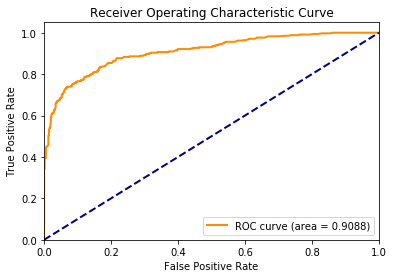

In [63]:
bcm.plot_roc_curve()

### Step 7
- Take a look at the test data - use DataFrame's ***createOrReplaceTempView*** method to perform SQL queries over the data
    - hint: check if there are any NULL values in the dataset - if so, handle them
- Apply the transformations to the test data
    - hint: include the model to the pipeline
- Make predictions using the model previously trained and the transformed test data

In [72]:
# Make the test set a "table"
testFilled.createOrReplaceTempView('test')

# Runs a series of SQL queries to get the number of null values in the test set
print({col: sqlc.sql("select * from test where " + col + " is null").count() for col in testFilled.columns})

# So, there is one null Fare, let's check it
sqlc.sql("select * from test where Fare is null").toPandas()

# Since the Fare is highly dependent on the class, it makes more sense to use the average for the given class
# But we need to take the average from the TRAINING set
trainFilled.createOrReplaceTempView('train')
avgFare = sqlc.sql("select mean(Fare) from train where Pclass = 3").take(1)[0][0]
print(avgFare)

# Fill the missing value with the calculated average
testFilled = testFilled.na.fill({'Fare': avgFare})

{'PassengerId': 0, 'Pclass': 0, 'Name': 0, 'Sex': 0, 'Age': 0, 'SibSp': 0, 'Parch': 0, 'Ticket': 0, 'Fare': 1, 'Cabin': 327, 'Embarked': 0}
13.675550101832997


In [76]:
sqlc.sql("select * from test where Fare is null").toPandas()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,None,None,S


In [73]:
predictions_test = model2.transform(testFilled)
predictions_test.limit(5).toPandas()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,nSex,vEmbarked,vFeatures,scaledFeat,rawPrediction,probability,prediction,lr_raw,lr_prob,lr_pred
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,None,...,0.0,"(0.0, 0.0)","(3.0, 34.5, 0.0, 0.0, 7.8292, 0.0, 0.0, 0.0)","[0.8269128165243681, 0.36924140369716385, -0.4...","[44.41379035443773, 5.58620964556226]","[0.8882758070887549, 0.11172419291124523]",0.0,"[2.1329079936915036, -2.1329079936915036]","[0.8940607579958335, 0.10593924200416652]",0.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,None,...,1.0,"(1.0, 0.0)","[3.0, 47.0, 1.0, 0.0, 7.0, 1.0, 1.0, 0.0]","[0.8269128165243681, 1.3306308331604593, 0.432...","[28.008736816383912, 21.991263183616095]","[0.5601747363276781, 0.43982526367232183]",0.0,"[0.611198993294568, -0.611198993294568]","[0.6482142601216717, 0.35178573987832823]",0.0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,None,...,0.0,"(0.0, 0.0)","(2.0, 62.0, 0.0, 0.0, 9.6875, 0.0, 0.0, 0.0)","[-0.36915750737695474, 2.4842981485164137, -0....","[41.281889793357, 8.718110206642999]","[0.82563779586714, 0.17436220413285997]",0.0,"[2.117741392200027, -2.117741392200027]","[0.8926156271505775, 0.10738437284942257]",0.0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,None,...,0.0,"(1.0, 0.0)","(3.0, 27.0, 0.0, 0.0, 8.6625, 0.0, 1.0, 0.0)","[0.8269128165243681, -0.2075922539808134, -0.4...","[43.51571989356966, 6.484280106430341]","[0.8703143978713932, 0.12968560212860683]",0.0,"[2.215017271335463, -2.215017271335463]","[0.9015899844708569, 0.09841001552914314]",0.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,None,...,1.0,"(1.0, 0.0)","[3.0, 22.0, 1.0, 1.0, 12.2875, 1.0, 1.0, 0.0]","[0.8269128165243681, -0.5921480257661316, 0.43...","[26.31555782003473, 23.684442179965274]","[0.5263111564006946, 0.47368884359930546]",0.0,"[-0.29611778684255774, 0.29611778684255774]","[0.42650679562305494, 0.5734932043769451]",1.0


### Step 8

- Load the answers for the ***test*** data
- Combine it with your predictions into a single DataFrame
- Use the evaluator you created on ***Step 6***
- What was your score?

In [74]:
answers = sqlc.read.csv('titanic_answers.csv', header=True)
answers = answers.select('PassengerId',F.col('Survived').cast('Double'))

pred_answer = predictions_test.join(answers, on='PassengerId')

roc = evaluator.evaluate(pred_answer)
print(roc)
acc = ev2.evaluate(pred_answer)
print(acc)

0.8159688412852969
0.7799043062200957


In [75]:
pred_answer.limit(5).toPandas()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,vEmbarked,vFeatures,scaledFeat,rawPrediction,probability,prediction,lr_raw,lr_prob,lr_pred,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,None,...,"(0.0, 0.0)","(3.0, 34.5, 0.0, 0.0, 7.8292, 0.0, 0.0, 0.0)","[0.8269128165243681, 0.36924140369716385, -0.4...","[44.41379035443773, 5.58620964556226]","[0.8882758070887549, 0.11172419291124523]",0.0,"[2.1329079936915036, -2.1329079936915036]","[0.8940607579958335, 0.10593924200416652]",0.0,0.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,None,...,"(1.0, 0.0)","[3.0, 47.0, 1.0, 0.0, 7.0, 1.0, 1.0, 0.0]","[0.8269128165243681, 1.3306308331604593, 0.432...","[28.008736816383912, 21.991263183616095]","[0.5601747363276781, 0.43982526367232183]",0.0,"[0.611198993294568, -0.611198993294568]","[0.6482142601216717, 0.35178573987832823]",0.0,1.0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,None,...,"(0.0, 0.0)","(2.0, 62.0, 0.0, 0.0, 9.6875, 0.0, 0.0, 0.0)","[-0.36915750737695474, 2.4842981485164137, -0....","[41.281889793357, 8.718110206642999]","[0.82563779586714, 0.17436220413285997]",0.0,"[2.117741392200027, -2.117741392200027]","[0.8926156271505775, 0.10738437284942257]",0.0,0.0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,None,...,"(1.0, 0.0)","(3.0, 27.0, 0.0, 0.0, 8.6625, 0.0, 1.0, 0.0)","[0.8269128165243681, -0.2075922539808134, -0.4...","[43.51571989356966, 6.484280106430341]","[0.8703143978713932, 0.12968560212860683]",0.0,"[2.215017271335463, -2.215017271335463]","[0.9015899844708569, 0.09841001552914314]",0.0,0.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,None,...,"(1.0, 0.0)","[3.0, 22.0, 1.0, 1.0, 12.2875, 1.0, 1.0, 0.0]","[0.8269128165243681, -0.5921480257661316, 0.43...","[26.31555782003473, 23.684442179965274]","[0.5263111564006946, 0.47368884359930546]",0.0,"[-0.29611778684255774, 0.29611778684255774]","[0.42650679562305494, 0.5734932043769451]",1.0,1.0
